# Installing Library

In [1]:
!pip install scipy numpy matplotlib

In [2]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Data Init and Ploting

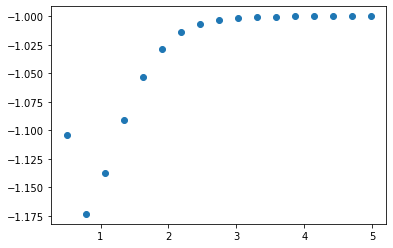

In [3]:
%matplotlib inline
x_raw = np.loadtxt('R_451.dat')
y_raw = np.loadtxt('E_FCI_451.dat')
idx = np.arange(0, 451, int(451/16))
x, y = x_raw[idx], y_raw[idx]  # training data, size: (16,)
X = np.linspace(0.5, 5, 200)   # predict at x ranging from 0.5 to 5, use 200 points
plt.plot(x, y, 'o')

# GPR Formula and Inplementation

## calculation formula

$$\left [ \begin{matrix} f(x) \\ \boldsymbol{y}^* \end{matrix} \right ] \sim \mathcal{N} \left (  \left [ \begin{matrix} \mu_f \\ \mu_y \end{matrix} \right ]  ,  \left [ \begin{matrix} K_{ff} & K_{fy} \\ k_{fy}^T & K_{yy}  \end{matrix} \right ]  \right ) \tag{1} $$

$$K_{ff} = k(x,x),\quad k_{fy}=k(x,x^*), \quad k_{yy}=k(x^*,x^*) \tag{2} $$

$$f \sim \mathcal{N}(K_{fy}^T (K_{ff}^{-1}+\sigma^2I_n)\boldsymbol{y}, \; K_{yy}-K_{fy}^T(K_{ff}^{-1}+\sigma^2I_n)^{-1}K_{fy} ) \tag{3}$$

formula 1: distribution of GPR with the training point and prediction point (f: training point, y: prediction point)

formula 2: 
 - $K_{ff}$ size: (N, N)
 - $K_{fy}$ size: (N, k)
 - $K_{yy}$ size: (k, k)
 
formula 3: 
 - mean function: $ m = K_{fy}^T (K_{ff}^{-1}+\sigma^2I_n)\boldsymbol{y}$
 - cov function: $cov = K_{yy}-K_{fy}^T(K_{ff}^{-1}+\sigma^2I_n)^{-1}K_{fy}$
 
 here the $\sigma$ in mean and cov function is $\alpha$ in the implementation code


## hyperparameter optimization formula (to minize a negative_log_likelihood_loss function)
$$\log p(\boldsymbol{y} | \sigma, l ) = \log \mathcal{N}(\mathbf{0}, K_{yy}(\sigma, l) ) =  -\frac12 \boldsymbol{y}^T K_{yy}^{-1}\boldsymbol{y} - \frac12 \log |K_{yy}| - \frac N2 \log (2\pi )$$ 


## Kernel

### RBF kernel
$$ K(x_1, x_2) = \sigma^2\exp{\left(-\frac{||x_1-x_2||^2}{2l^2}\right)} $$

### Exponential Kernel
$$ K(x_1, x_2) = \sigma^2\exp{\left(-\frac{||x_1-x_2||}{l}\right)} $$

### Mater 3/2 Kernel
$$ K(x_1, x_2) = \sigma^2 \left ( 1 + \frac{\sqrt{3}||x_1-x_2||}{l}   \right ) \exp{\left(-\frac{\sqrt{3} ||x_1-x_2||}{l}\right)} $$

### Rational Quadratic Kernel
$$ K(x_1, x_2) = \sigma^2 \left ( 1 + \frac{||x_1-x_2||^2}{2\alpha l^2 }   \right ) ^{-\alpha} $$


In [4]:
class GPR():
    def __init__(self, kernel='RBF', optimizer='L-BFGS-B', opt_params=None, bounds=None, **kw):
        self.optimizer = optimizer           # optimizer defined in scipy.optimize.minize
        self.kernel = getattr(self, kernel)  # get kernel with name: RBF Exponential Matern RationalQuadratic
        self.params = {                      # initial parameter.
            "l": 0.5,       # l: length_scale in kernel formula
            "sigma": 0.2,   # sigma: σ in kernel
            "alpha": 1e-8   # alpha: σ in cov function
        }
        self.opt_params = opt_params  # a list/tuple with the name of the parameter needs to be optimized, e.g. ['l', 'sigma']
        self.bounds = bounds          # the lower and upper bound with the same order to opt_params, e.g. [(1e-4. 1e4), (1e-5, 1e3)]
        for k, v in kw.items():       # set other parameter in kernel, e.g. 'kernel_alpha' in RationalQuadratic
            self.params[k] = v
        self.is_fit = False           # fit flag
        self.train_X, self.train_y = None, None  # var to store training data

    def predict(self, X, return_std=False):
        X = np.asarray(X)    # convert to numpy object
        # if not fited, return the prior distribution
        if not self.is_fit:  
            mean = np.zeros(X.shape[0])   # mean = 0.0  size: (N,)
            cov = self.kernel(X, X)       # cov = K(x_train, x_train)
            if return_std:   # return std instead of cov
                return mean, np.sqrt(np.diag(cov))
            return mean, cov
        # if fitted, make prediction  
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + self.params["alpha"] * np.eye(len(self.train_X)))  # (N, N)
        
        mu = Kfy.T.dot(Kff_inv).dot(self.train_y).ravel()  # mean fuction
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)            # cov function
        if return_std:    # return std instead of cov
            return mu, np.sqrt(np.diag(cov))
        return mu, cov

    def RBF(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)        
    
    def Exponential(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        dist_matrix = dist_matrix ** 0.5
        return self.params['sigma']**2 * np.exp(-1/self.params['l'] * dist_matrix)
        
    def Matern(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        dist_matrix = dist_matrix ** 0.5
        tmp1 = 1 + 3**0.5 * dist_matrix / self.params['l']
        tmp2 = np.exp(-3**0.5 * dist_matrix / self.params['l'])
        return self.params['sigma'] * tmp1 * tmp2
    
    def RationalQuadratic(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        alpha = self.params['kernel_alpha']
        l = self.params['l']
        inner = 1 + dist_matrix / (2 * alpha * l**2)
        return self.params['sigma']**2 * inner**(-alpha)
        
    def sample_y(self, X, n_samples=5, random_state=0):   # sample many y curve with "n_samples" number and random seed "random_state"
        mean, cov = self.predict(X[:, np.newaxis])
        rs = np.random.RandomState(random_state)
        return rs.multivariate_normal(mean, cov, n_samples).T  # generate many y curve with multivariate normal method
    
    def negative_log_likelihood_loss(self, params):  # function to be minized
        for k, v in zip(self.opt_params, params):    # set the trial hyperparameter to GPR instance
            self.params[k] = v
        Kyy = self.kernel(self.train_X, self.train_X) + self.params["alpha"] * np.eye(len(self.train_X))
        loss = 0.5 * self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + \
               0.5 * np.linalg.slogdet(Kyy)[1] + \
               0.5 * len(self.train_X) * np.log(2 * np.pi)
        return loss.ravel()
    
    def fit(self, X, y):
        # convert to a numpy object
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)

        # hyper parameters optimization
        if self.optimizer and self.opt_params:
            res = minimize(self.negative_log_likelihood_loss, 
                           [self.params[k] for k in self.opt_params],  # initial guess of hyperparameter that is need to be optimized
                           bounds=self.bounds,     # bound of hyperparameter
                           method=self.optimizer)  # name of optimizer in scipy.optimize.minize
            for i, k in enumerate(self.opt_params):  # finally set the optimized hyperparameter
                self.params[k] = res.x[i]
        self.is_fit = True

In [5]:
def draw(gpr, title):
    plt.figure(figsize=(20, 6), dpi=300)  # set figure size and dpi
    
    plt.subplot(121)  # declare figure to 1 row 2 columns, and set the working area to 1st canvas
    ypred, std = gpr.predict(X[:, np.newaxis], return_std=True)  # prior result
    plt.plot(X, ypred, 'k', lw=2)  # plot prior result with black color (k) and set line width to 2
    plt.fill_between(X, ypred+1.96*std, ypred-1.96*std, alpha=0.2)  # fill the 95% confidential interval with transparency set to 0.2
    y_samples = gpr.sample_y(X, n_samples=10)  # sample 10 prior y curve with N( 0.0, k(x,x) )
    plt.plot(X, y_samples)  # plot sampled y curve
    plt.title('Prior'); plt.xlabel('R'); plt.ylabel('E, Hatree')

    plt.subplot(122)  # declare figure to 1 row 2 columns, and set the working area to 2nd canvas
    gpr.fit(x[:, np.newaxis], y[:, np.newaxis])  # fit training data
    ypred, std = gpr.predict(X[:, np.newaxis], return_std=True)   # make prediction at the test point (X)
    plt.plot(x, y, 'rx', label='train', markersize=10)  # plot training point with red color (r) and x target (x)
    plt.plot(X, ypred.ravel(), 'k', label='predict', lw=2)  # plot posterior result with black color (k) and set line width to 2
    plt.fill_between(X, ypred+1.96*std, ypred-1.96*std, alpha=0.2)  # fill the 95% confidential interval with transparency set to 0.2
    y_samples = gpr.sample_y(X, n_samples=5)  # sample 5 posterior y curve with trained model
    plt.plot(X, y_samples, alpha=0.5)  # plot sampled y curve with tranparency set to 0.5
    # set title with hyperparameter
    plt.title(r'Posterior'); 
    # plt.title(r'Posterior. l=%.4f, $\sigma$=%.4f, $\alpha$=%.4e' % (gpr.params['l'], gpr.params['sigma'], gpr.params['alpha'])); 
    plt.xlabel('R'); plt.ylabel('E, Hatree')
    plt.legend() # show the legend

    plt.suptitle(title)  # set super title
    plt.savefig(f'{title}.png')  # save figure

In [6]:
# initial guess of length_scale and σ in kernel
l = x.std()
sigma = y.std() / (2**0.5)
l, sigma

(1.3717142559585798, 0.03833548010485233)

# RBF Kernel

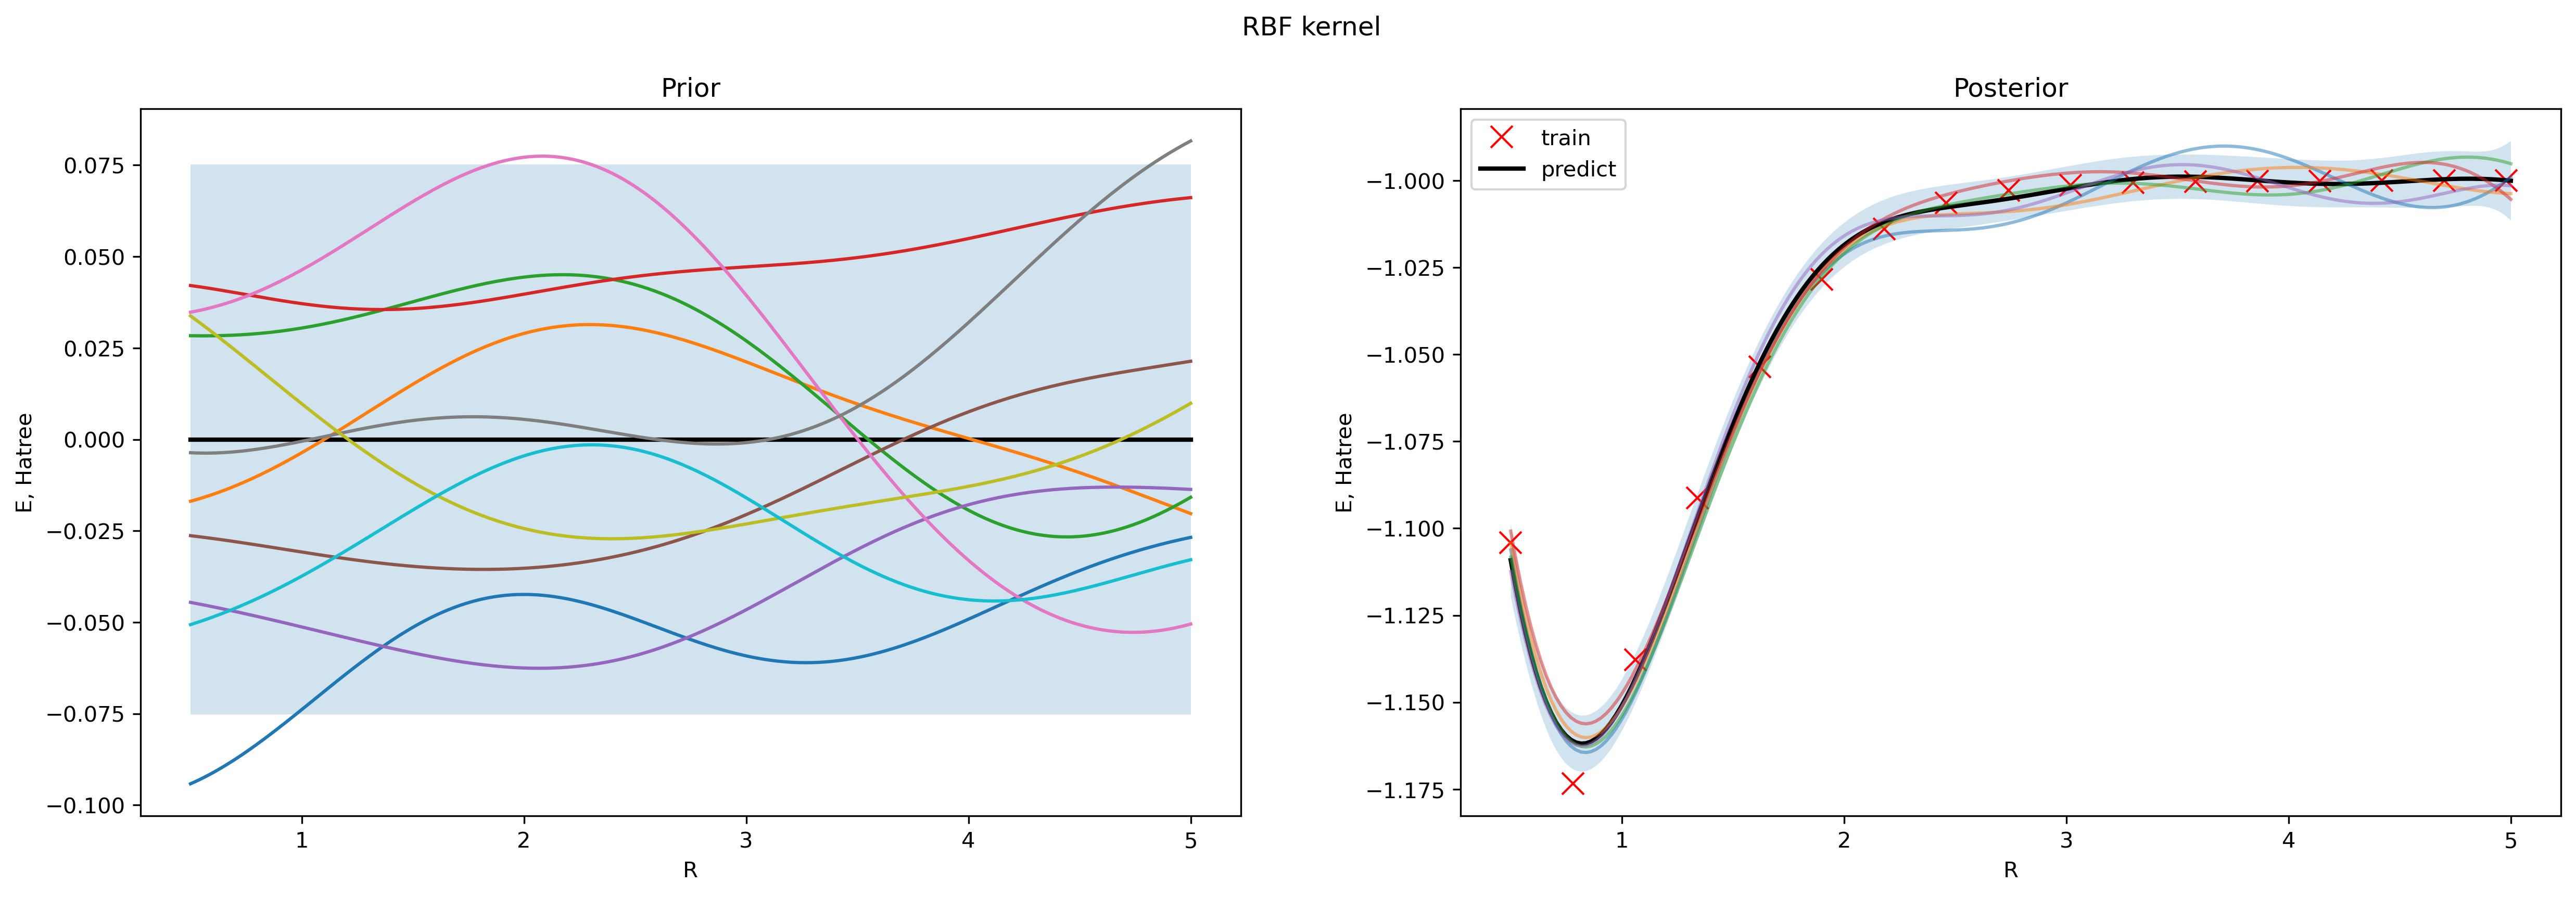

In [7]:
gpr = GPR(opt_params='l sigma alpha'.split(), 
          bounds=((1e-4, 1e4), (1e-4, 1e4), (1e-10, 1e4)), 
          l=l, sigma=sigma, alpha=1e-6)
draw(gpr, 'RBF kernel')

# Mater 3/2 Kernel

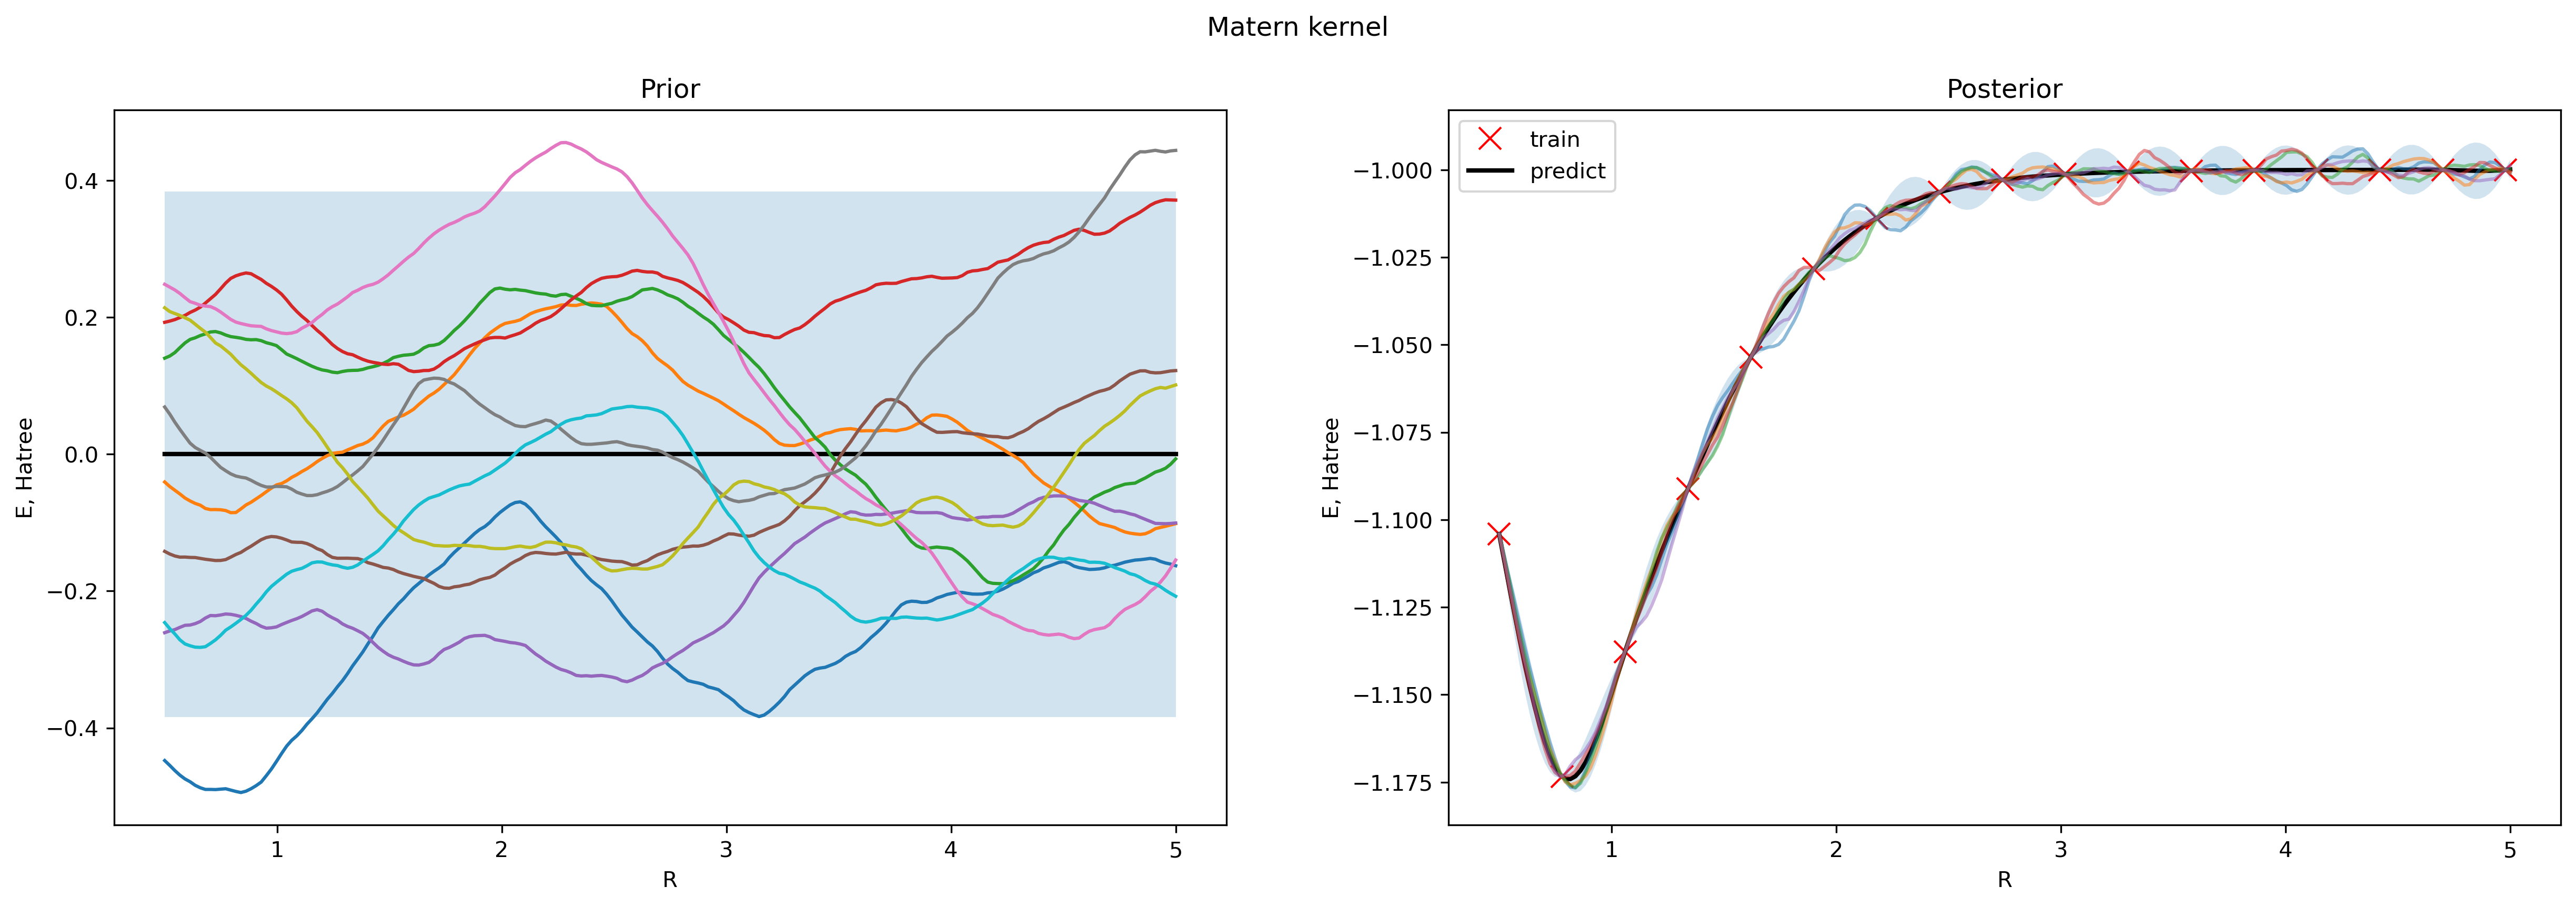

In [8]:
gpr = GPR(kernel='Matern', 
          opt_params='l sigma alpha'.split(),
          bounds=((1e-4, 1e4), (1e-4, 1e4), (1e-10, 1e4)),
          l=l, sigma=sigma, alpha=1e-6)
draw(gpr, 'Matern kernel')

# Exponential Kernel

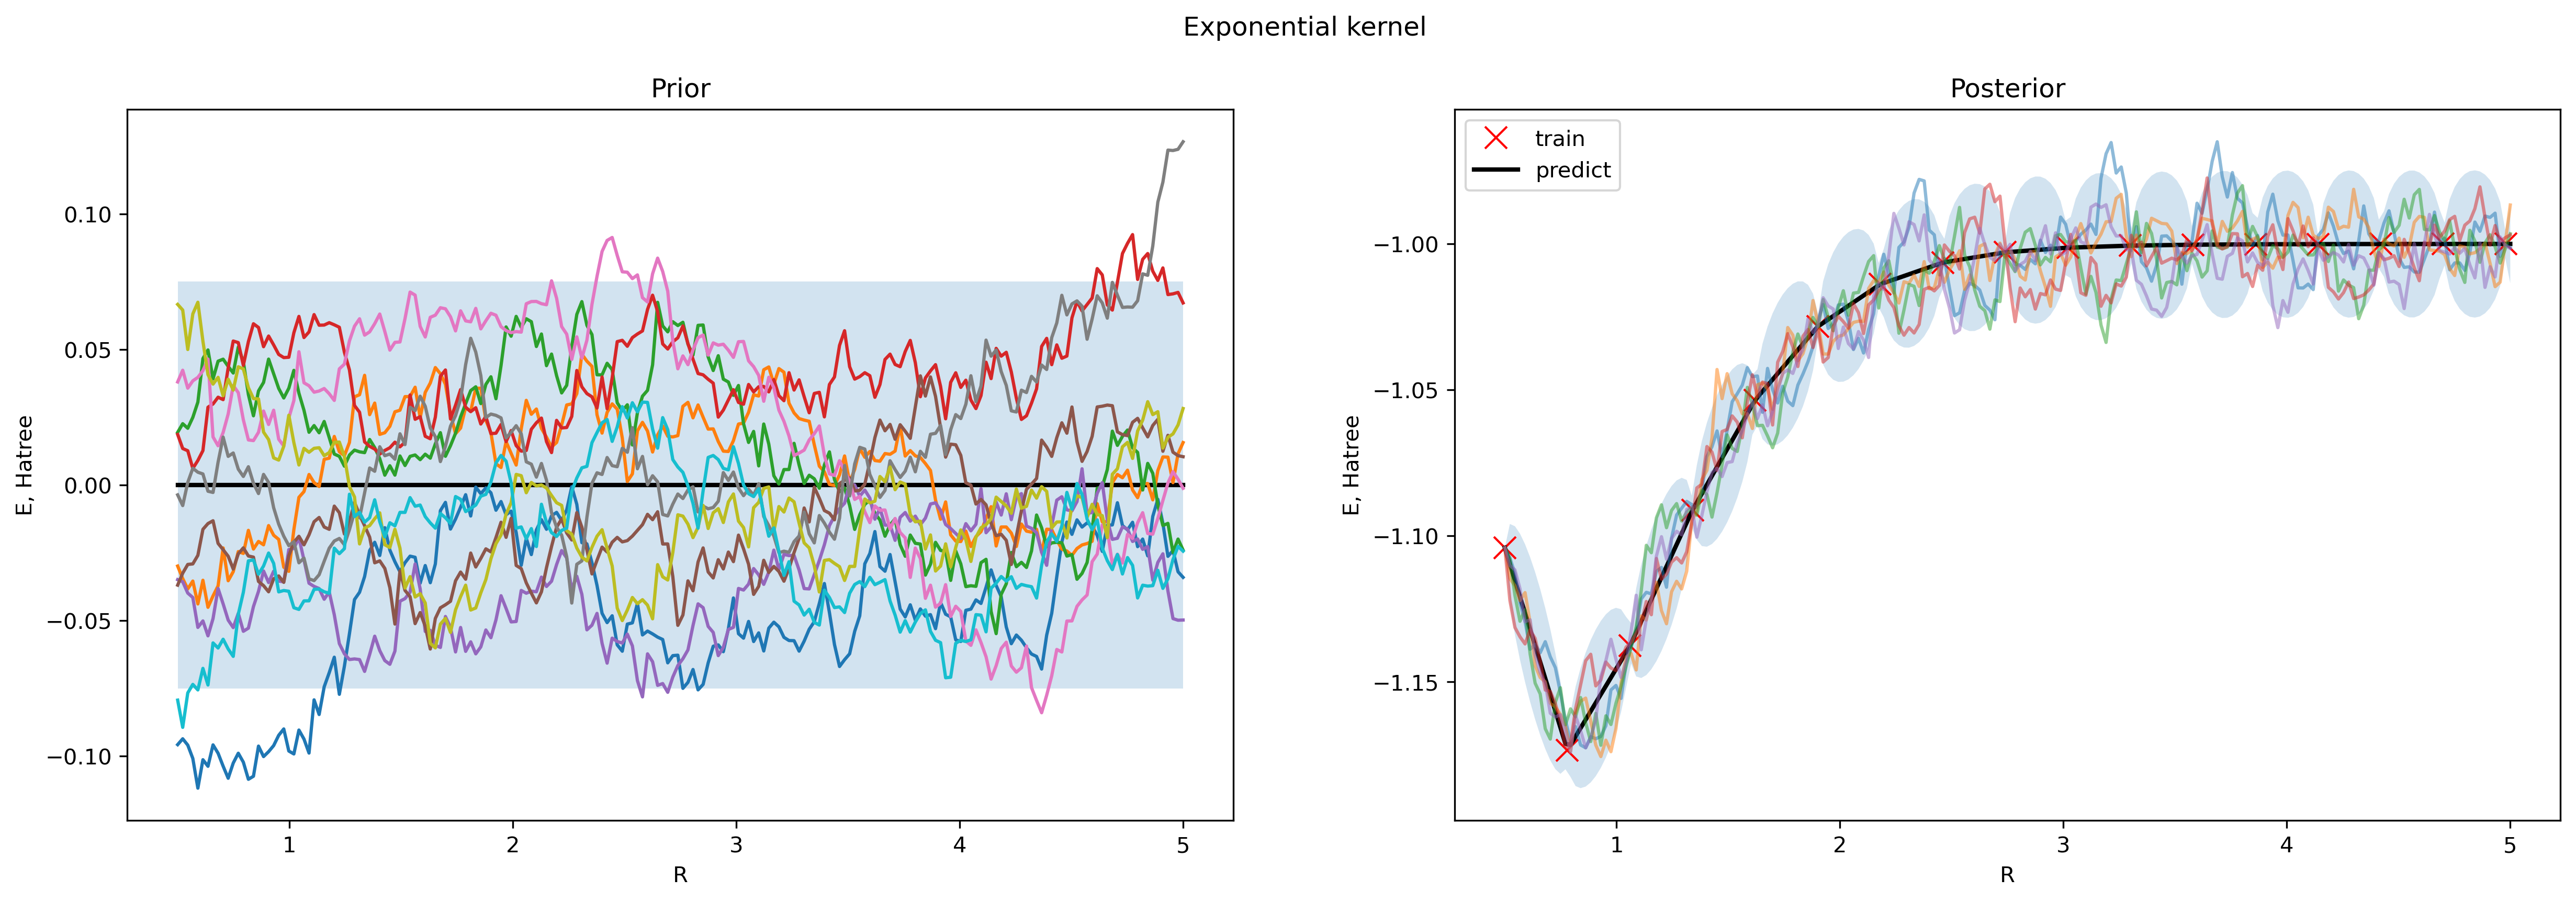

In [9]:
gpr = GPR(kernel='Exponential', 
          opt_params='l sigma alpha'.split(),
          bounds=((1e-4, 1e4), (1e-4, 1e4), (1e-10, 1e4)),
          l=l, sigma=sigma, alpha=1e-6)
draw(gpr, 'Exponential kernel')

# Rational Quadratic kernel

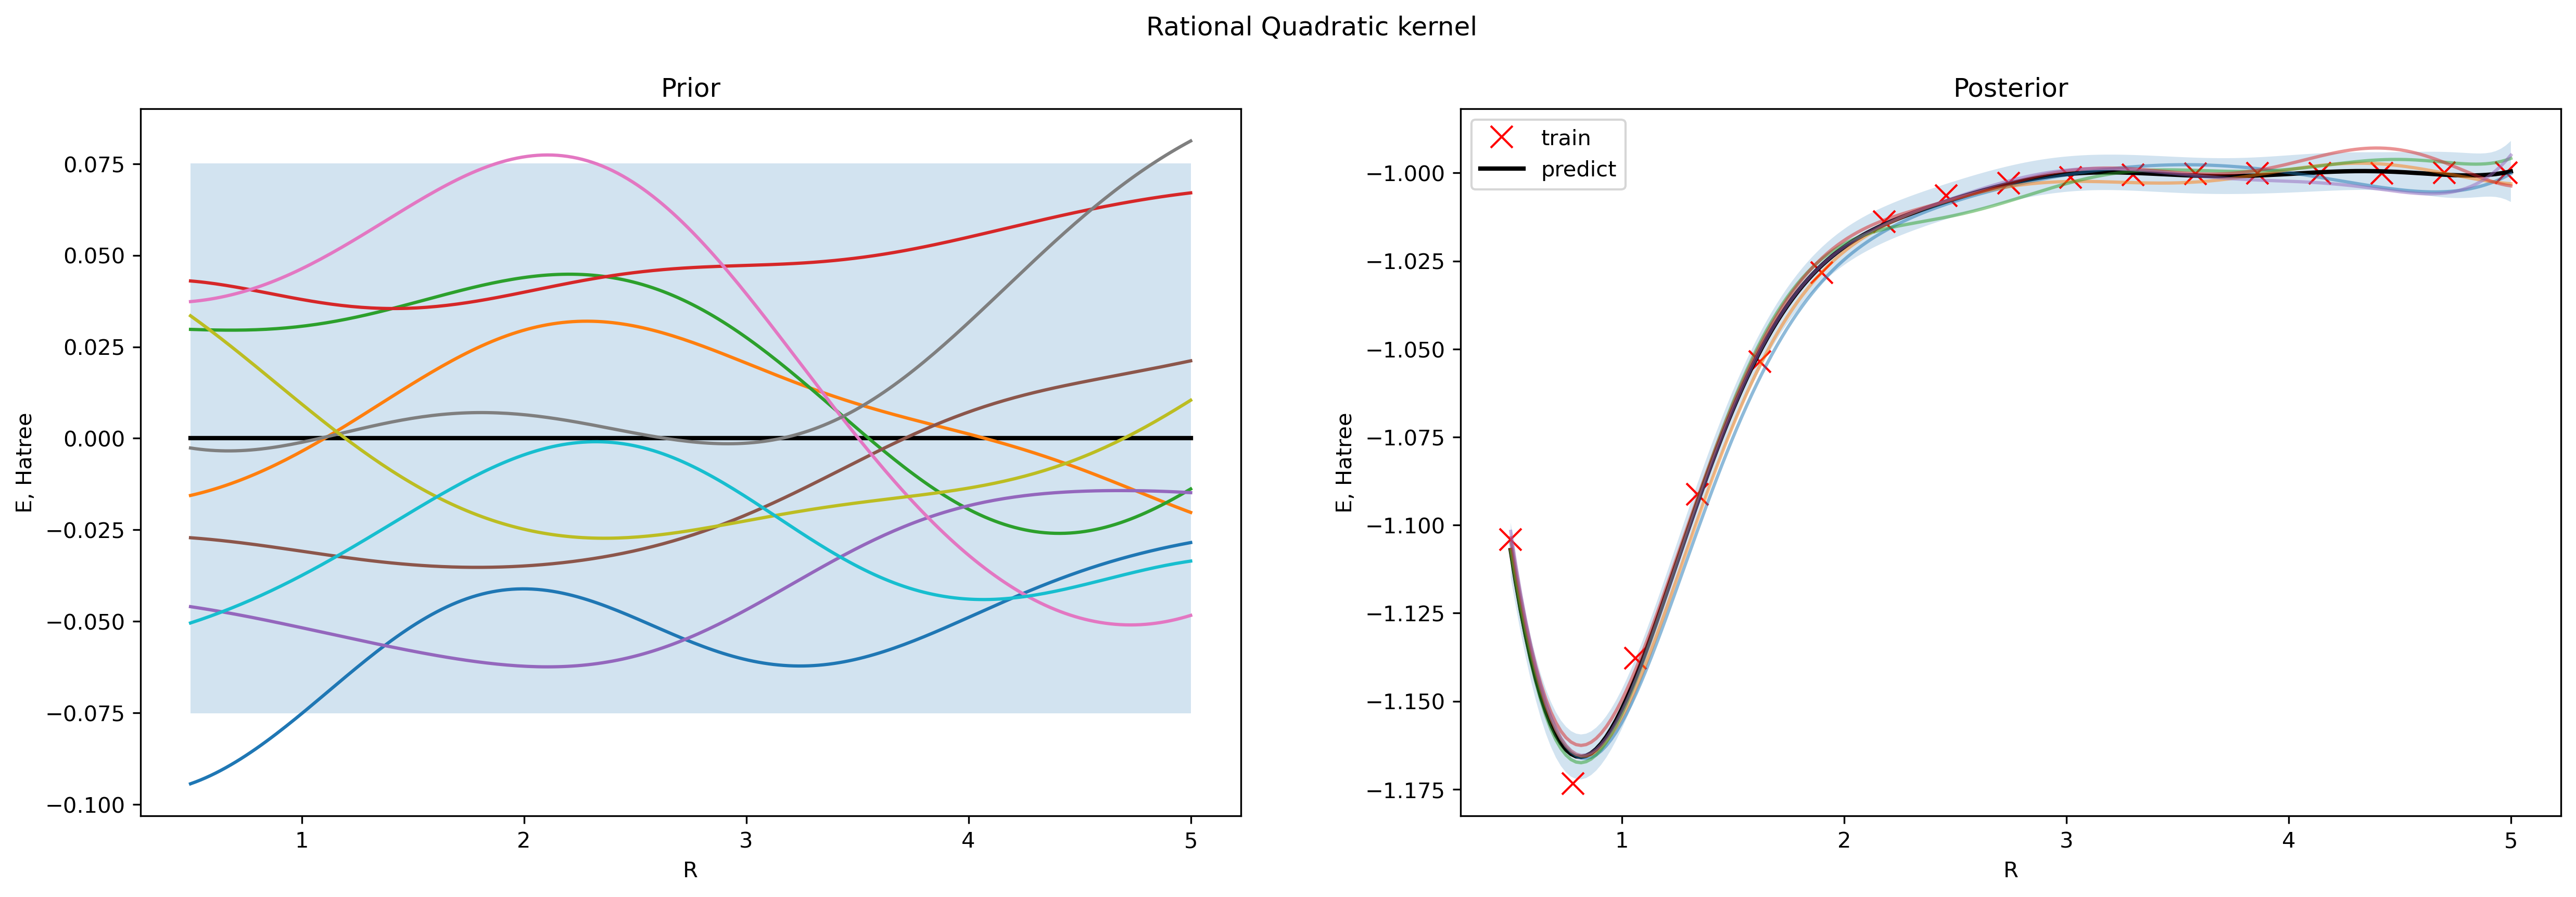

In [10]:
gpr = GPR(kernel='RationalQuadratic', 
          opt_params='l sigma alpha'.split(),
          bounds=[(1e-4, 1e4), (1e-4, 1e4), (1e-10, 1e4)],
          kernel_alpha=10,
          l=l, sigma=sigma, alpha=1e-6)
draw(gpr, 'Rational Quadratic kernel')